# Data Challenge 12 — Intro to Logistic Regression

**Hook (Attention Grabber)**  
> “If an app told a restaurant it has an 80% chance of getting an **A** on inspection, would you trust it?”

**Learning Goals**
- Show why **linear regression** is a bad fit for a **binary (0/1)** target.
- Fit a **one-feature logistic regression** and interpret probabilities.
- Extend to a **two-feature logistic model with standardized inputs**.
- Communicate results using **AWES** and discuss **ethics & people impact**.

**Data:** June 1, 2025 - Nov 4, 2025 Restaurant Health Inspection

[Restaurant Health Inspection](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- LinearRegression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- LogisticRegression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- StandardScaler — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- accuracy_score — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
- corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Linear vs Logistic + Scaling)
1) **Load CSV** → preview shape/columns; keep needed fields.  
2) **Engineer binary Y**: `is_A = 1 if grade == 'A' else 0`.  
3) **Pick numeric X**:  
   - **X1:** `score` (inspection score; lower is better)  
   - **X2:** `critical_num = 1 if critical_flag == 'Critical' else 0` (for extension)  
4) **Split** → `X_train, X_test, y_train, y_test` (70/30, stratify by Y, fixed random_state).  
5) **Model A (Incorrect)** → **LinearRegression** on Y~X1:  
   - Report **MSE**, **R²**, count predictions **<0 or >1**,  
6) **Model B (Correct)** → **LogisticRegression** on Y~X1:  
   - Report **Accuracy**
7) **Visual (OPTIONAL)** → scatter Y vs X1 with **linear line** vs **logistic sigmoid** curve  
8) **Extension** → scale X1+X2 with **StandardScaler**; fit **LogisticRegression**:  
   - Compare **Accuracy** to one-feature logistic  
9) **Interpret** → 2–3 sentences on why linear fails and how logistic fixes it  


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

## Step 1 — Imports and Plot Defaults

In [58]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 2 — Load CSV & Preview
- Point to your New York City Restaurant Inspection Data 

In [4]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251110.csv'
df = pd.read_csv(path)
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location
0,50167878,GOLDEN STEAMER I INC.,Manhattan,143,MOTT STREET,"10,013.0000",6465231688,NaN,01/01/1900,NaN,...,NaN,40.7187,-73.9966,102.0000,1.0000,"4,100.0000","1,079,581.0000","1,002,370,019.0000",MN24,POINT (-73.996645049413 40.718681310365)
1,50168599,THAI FLAVOR 88 INC.,Manhattan,174,2 AVENUE,"10,003.0000",2122542868,NaN,01/01/1900,NaN,...,NaN,40.7305,-73.9863,103.0000,2.0000,"4,000.0000","1,077,704.0000","1,004,530,001.0000",MN22,POINT (-73.986296382711 40.730463823842)
2,50162584,COZY TEA LOFT,0,141,STATE ROUTE 27,"8,820.0000",3472619435,NaN,01/01/1900,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50174672,EL PALENQUE MEXICAN RESTAURANT CORPORATION,Brooklyn,181,WEST END AVENUE,"11,235.0000",7182553580,NaN,01/01/1900,NaN,...,NaN,40.5773,-73.9530,315.0000,48.0000,"62,000.0000","3,245,985.0000","3,087,320,012.0000",BK17,POINT (-73.952961276652 40.577340234075)
4,50155679,ZADDY'S JERK CHICKEN,Brooklyn,686,HEGEMAN AVENUE,"11,207.0000",7187752616,NaN,01/01/1900,NaN,...,NaN,40.6621,-73.8866,305.0000,42.0000,"110,400.0000","3,097,445.0000","3,043,290,001.0000",BK82,POINT (-73.886623536611 40.662080196538)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291700,41658103,CHOP-SHOP,Manhattan,254,10 AVENUE,"10,001.0000",2128200333,Asian/Asian Fusion,01/25/2023,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.7488,-74.0034,104.0000,3.0000,"9,300.0000","1,012,823.0000","1,007,220,076.0000",MN13,POINT (-74.003374516952 40.748763929496)
291701,50096822,SOHO THAI,Manhattan,141,GRAND STREET,"10,013.0000",2129668916,Thai,02/20/2024,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.7202,-73.9995,102.0000,1.0000,"4,500.0000","1,003,045.0000","1,002,330,012.0000",MN24,POINT (-73.999502156932 40.720240386394)
291702,50016367,EL MANATIAL,Queens,104-21,ROOSEVELT AVENUE,"11,368.0000",7185050250,Latin American,08/28/2025,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.7501,-73.8607,403.0000,21.0000,"40,300.0000","4,307,628.0000","4,017,760,061.0000",QN26,POINT (-73.860725144918 40.750139665657)
291703,41236413,DUNKIN,Brooklyn,1575,FLATBUSH AVENUE,"11,210.0000",3474057014,Donuts,03/18/2025,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.6324,-73.9472,314.0000,45.0000,"78,600.0000","3,205,908.0000","3,075,580,031.0000",BK42,POINT (-73.947175876843 40.632384405769)


## Step 3 — Clean and Engineer Features
- Make sure `SCORE` is numeric and do any other data type clean-up 
- Engineer binary target variable (Y) based on instructor guidance above `is_A`
- Engineer binary predictor (X) based on instructor guidance above `critical_num`


In [5]:
df.dtypes

CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
Latitude                 float64
Longitude                float64
Community Board          float64
Council District         float64
Census Tract             float64
BIN                      float64
BBL                      float64
NTA                       object
Location                  object
dtype: object

In [17]:
display(df['GRADE'].unique())
display(df['BORO'].value_counts())

array([nan, 'A', 'P', 'C', 'N', 'Z', 'B'], dtype=object)

BORO
Manhattan        108054
Brooklyn          74970
Queens            71817
Bronx             26801
Staten Island     10039
0                    24
Name: count, dtype: int64

In [7]:
df_cleaned = df.dropna(subset=['SCORE', 'GRADE', 'CRITICAL FLAG'])
df_cleaned['GRADE']

12        A
19        A
22        A
33        P
71        C
         ..
291697    A
291698    A
291700    B
291701    A
291703    A
Name: GRADE, Length: 142309, dtype: object

In [18]:
df_cleaned

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location,is_A,is_critical
12,50070543,CLARO,Manhattan,284,3 AVENUE,"10,010.0000",3477213126,Mexican,09/23/2022,Violations were cited in the following area(s).,...,-73.9835,106.0000,2.0000,"6,800.0000","1,018,020.0000","1,008,780,036.0000",MN21,POINT (-73.98353061908 40.73831623132),1,1
19,41708524,REICHENBACH HALL,Manhattan,5,WEST 37 STREET,"10,018.0000",2123027744,German,05/09/2024,Violations were cited in the following area(s).,...,-73.9837,105.0000,4.0000,"8,400.0000","1,080,734.0000","1,008,390,034.0000",MN17,POINT (-73.983744126629 40.750585348897),1,0
22,41086967,IL SOLE,Manhattan,229233,DYCKMAN STREET,NaN,2125440406,Italian,01/04/2024,Violations were cited in the following area(s).,...,0.0000,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,1,1
33,50070454,Sushi Q,Bronx,1610,CROSBY AVENUE,"10,461.0000",7188221627,Japanese,06/24/2024,Establishment re-opened by DOHMH.,...,-73.8305,210.0000,13.0000,"26,602.0000","2,098,281.0000","2,041,680,008.0000",BX10,POINT (-73.830521390885 40.844216634976),0,0
71,41543970,PAUSE CAFE,Manhattan,3,CLINTON SREET,NaN,2126775415,Middle Eastern,02/28/2022,Violations were cited in the following area(s).,...,0.0000,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291697,50017044,JUST SALAD,Manhattan,90,BROAD STREET,"10,004.0000",6467964322,Salads,02/28/2024,Violations were cited in the following area(s).,...,-74.0116,101.0000,1.0000,900.0000,"1,000,025.0000","1,000,100,016.0000",MN25,POINT (-74.011591848104 40.703946851643),1,0
291698,40903960,BELLEROSE FAMOUS PIZZA,Queens,24822,UNION TURNPIKE,"11,426.0000",7183472100,Pizza,02/10/2025,Violations were cited in the following area(s).,...,-73.7217,413.0000,23.0000,"157,101.0000","4,174,405.0000","4,085,610,001.0000",QN43,POINT (-73.721702385884 40.742440120763),1,0
291700,41658103,CHOP-SHOP,Manhattan,254,10 AVENUE,"10,001.0000",2128200333,Asian/Asian Fusion,01/25/2023,Violations were cited in the following area(s).,...,-74.0034,104.0000,3.0000,"9,300.0000","1,012,823.0000","1,007,220,076.0000",MN13,POINT (-74.003374516952 40.748763929496),0,0
291701,50096822,SOHO THAI,Manhattan,141,GRAND STREET,"10,013.0000",2129668916,Thai,02/20/2024,Violations were cited in the following area(s).,...,-73.9995,102.0000,1.0000,"4,500.0000","1,003,045.0000","1,002,330,012.0000",MN24,POINT (-73.999502156932 40.720240386394),1,1


In [19]:
# Creating our Y: is_A
df_cleaned['is_A'] = (df_cleaned['GRADE']=='A').astype(int)
df_cleaned['is_A'].value_counts()

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_71956/1304343959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['is_A'] = (df_cleaned['GRADE']=='A').astype(int)


is_A
1    96414
0    45895
Name: count, dtype: int64

In [9]:
df_cleaned['is_critical'] = (df_cleaned['CRITICAL FLAG']=='Critical').astype(int)
df_cleaned['is_critical'].value_counts()

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_71956/2604683436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['is_critical'] = (df_cleaned['CRITICAL FLAG']=='Critical').astype(int)


is_critical
1    71637
0    70672
Name: count, dtype: int64

<Axes: xlabel='SCORE', ylabel='is_A'>

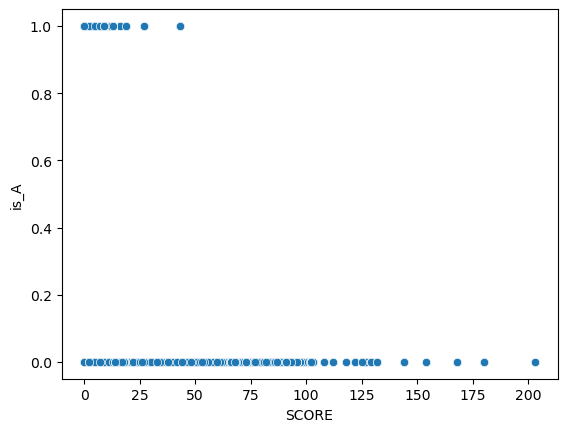

In [10]:
# Taking a look at our X's
sns.scatterplot(df_cleaned, x='SCORE', y='is_A')

<Axes: xlabel='is_critical', ylabel='is_A'>

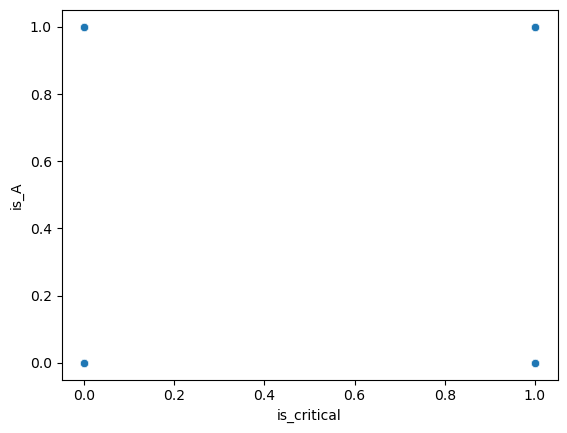

In [11]:
sns.scatterplot(df_cleaned, x='is_critical', y='is_A')

## Step 4 — Split Data (70/30 Stratify by Target)

In [38]:
# adding constant + y variable
X = sm.add_constant(df_cleaned['SCORE'])
y = df_cleaned['is_A']
# train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=42)

## Step 5 — Model A: Linear Regression on a Binary Target (Incorrect)

- Fit `is_A (Y var) ~ SCORE (X pred)` using **LinearRegression**  
- Report **MSE**, **R²**, and how many predictions fall outside [0, 1]  
- Estimate accuracy by thresholding predictions at 0.5 (done for you but understand the code) 

💡 Hint:  
`accuracy_score(y_test, (y_pred >= 0.5).astype(int))`

In [57]:
model_SLR = sm.OLS(y_train, x_train).fit()
y_pred = model_SLR.predict(x_test)
model_SLR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   is_A   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                 1.018e+05
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:58:51   Log-Likelihood:                -30521.
No. Observations:               99616   AIC:                         6.105e+04
Df Residuals:                   99614   BIC:                         6.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0929      0.002    655.532      0.000       1.090       1.096
SCORE         -0.0250   7.82e-05   -319.074      0.000      -0.025      -0.025
==============================================================================
Omnibus:                    13060.498   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81465.161
Skew:                          -0.471   Prob(JB):                         0.00
Kurtosis:                       7.329   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
accuracy_score(y_test, (y_pred >= 0.5).astype(int))

0.8839388190101422

## Step 6 — Model B: Logistic Regression (One Feature)

- Fit `is_A ~ score` using **LogisticRegression**  
- Compute predictions with `.predict()`  
- Evaluate accuracy with `accuracy_score()`

In [47]:
log_mod = sm.Logit(y_train, x_train).fit()
log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.164473
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   is_A   No. Observations:                99616
Model:                          Logit   Df Residuals:                    99614
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.7384
Time:                        14:30:26   Log-Likelihood:                -16384.
converged:                       True   LL-Null:                       -62632.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7936      0.070    140.355      0.000       9.657       9.930
SCORE         -0.6005      0.005   -120.987      0.000      -0.610      -0.591
==============================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [70]:
# log model statistics
log_reg = LogisticRegression(random_state=42).fit(x_train, y_train)
# prediction
y_pred2 = log_reg.predict(x_test)

In [ ]:
# coefficient + intercept
coef = log_reg.coef_[0][0]
intercept = log_reg.intercept_[0]

print(f"Intercept (Log-Odds): {intercept:.4f}")
print(f"Coefficient (Log-Odds): {coef:.4f}")

Intercept (Log-Odds): 4.8908
Coefficient (Log-Odds): 4.8904


In [ ]:
# baseline odds + odds ratio
baseline_odds = np.exp(intercept)
odds_ratio = np.exp(coef)

print(f"\nBaseline Odds: {baseline_odds:.4f}")
print(f"Odds Ratio for 'SCORE' & 'is_critical': {odds_ratio:.4f}")


Baseline Odds: 133.0631
Odds Ratio for 'SCORE' & 'is_critical': 133.0118


In [71]:
# accuracy score for log_mod 1 feature
accuracy_score(y_test, (y_pred2 >= 0.5).astype(int))

0.9678635841941302

Now THAT is way more accriate (⊙ _ ⊙ )

## Step 7 (OPTIONAL) — Visual Comparison: Linear vs Logistic


In [44]:
None

## Step 8 — Logistic Regression with Two **Scaled** Features

- Use `SCORE` and `critical_num` as your two X predictors that need to be scaled
- Look at documentation above to see how you would fit a StandardScalar() object 


In [66]:
# adding constant + y variable
X2 = sm.add_constant(df_cleaned[['SCORE', 'is_critical']])
y2 = df_cleaned['is_A']
# train-test split
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, test_size=0.3, stratify=y2, random_state=42)
# created scaler oject and scaled for our two variables (train & test)
scaler = StandardScaler()
# x2 train
x2_train_scaled = scaler.fit_transform(x2_train)
#x2 test
x2_test_scaled = scaler.fit_transform(x2_test)

# We Share — Reflection & Wrap-Up

Write **two short paragraphs** (4–6 sentences each). Be specific and use evidence from your notebook.

1️⃣ **How do you know Linear Regression was a poor model choice for this task?**  
Describe what you observed in your results or plots that showed it didn’t work well for a binary outcome.  
Consider: Were predictions outside 0–1? Did the fit look wrong? What happened when you used 0.5 as a cutoff?  
Connect this to the idea that classification models should output probabilities between 0 and 1.

2️⃣ **When should we scale features in logistic regression (and when not to)?**  
Explain what scaling does, and why it might (or might not) matter for different kinds of features.  
Use this project to reason through whether `score` and `critical_num` needed scaling.  
Hint: Think about what “continuous” vs “binary” means for scaling decisions.